# Курсовая работа
## Датасет: [Messy vs Clean Room](https://www.kaggle.com/datasets/cdawn1/messy-vs-clean-room)
### Выполнил Попов Матвей, группа М8О-114СВ-24


## О датасете

Используется для задач распознавания степени убранности комнаты. Содержит 212 
изображений комнат, которые распределены на 2 категории:

* Messy (беспорядок)
* Tidy (порядок)

Каждое изображение цветное, разрешение 299x299 пикселей. Датасет представлен в 
виде архива изображений, для каждого класса представлена своя директория.


## Обучение модели-классификатора изображений


Подкючаем необходимые импорты

In [29]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import time
import os
from PIL import Image
from tempfile import TemporaryDirectory


Загружаем датасет

In [32]:
!curl -L -o messy-vs-clean-room.zip https://www.kaggle.com/api/v1/datasets/download/cdawn1/messy-vs-clean-room

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 67.1M  100 67.1M    0     0  8478k      0  0:00:08  0:00:08 --:--:-- 10.0M8k      0  0:00:08  0:00:06  0:00:02  9.9M


In [33]:
!unzip messy-vs-clean-room.zip -d dataset

Archive:  messy-vs-clean-room.zip
  inflating: dataset/images/images/test/0.png  
  inflating: dataset/images/images/test/1.png  
  inflating: dataset/images/images/test/2.png  
  inflating: dataset/images/images/test/3.png  
  inflating: dataset/images/images/test/4.png  
  inflating: dataset/images/images/test/5.png  
  inflating: dataset/images/images/test/6.png  
  inflating: dataset/images/images/test/7.png  
  inflating: dataset/images/images/test/8.png  
  inflating: dataset/images/images/test/9.png  
  inflating: dataset/images/images/train/clean/0.png  
  inflating: dataset/images/images/train/clean/1.png  
  inflating: dataset/images/images/train/clean/10.png  
  inflating: dataset/images/images/train/clean/11.png  
  inflating: dataset/images/images/train/clean/12.png  
  inflating: dataset/images/images/train/clean/13.png  
  inflating: dataset/images/images/train/clean/14.png  
  inflating: dataset/images/images/train/clean/15.png  
  inflating: dataset/images/images/train

In [34]:
cudnn.benchmark = True
plt.ion()

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = './dataset/images/images'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


Выведем структуру датасета

In [35]:
dataset_sizes

{'train': 192, 'val': 20}

In [36]:
class_names

['clean', 'messy']

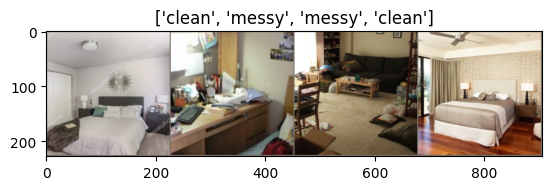

In [37]:
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

inputs, classes = next(iter(dataloaders['train']))

out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])


### Обучение модели

Используем предобученную модель ResNet-18


In [38]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')

        torch.save(model.state_dict(), best_model_params_path)
        best_acc = 0.0

        for epoch in range(num_epochs):
            print(f'Epoch {epoch}/{num_epochs - 1}')
            print('-' * 10)
            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()
                else:
                    model.eval()

                running_loss = 0.0
                running_corrects = 0

                for inputs, labels in dataloaders[phase]:
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    optimizer.zero_grad()

                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)

                if phase == 'train':
                    scheduler.step()

                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]

                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

                if phase == 'val' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    torch.save(model.state_dict(), best_model_params_path)
            
            print()

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best val Acc: {best_acc:4f}')
        model.load_state_dict(torch.load(best_model_params_path))
    return model


In [39]:
model_conv = torchvision.models.resnet18(weights='IMAGENET1K_V1')

for param in model_conv.parameters():
    param.requires_grad = False

num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)
model_conv = model_conv.to(device)
criterion = nn.CrossEntropyLoss()
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)


In [40]:
model_conv = train_model(model_conv, criterion, optimizer_conv, exp_lr_scheduler, num_epochs=25)


Epoch 0/24
----------
train Loss: 0.8136 Acc: 0.5417
val Loss: 0.3688 Acc: 0.9000

Epoch 1/24
----------
train Loss: 0.4541 Acc: 0.7969
val Loss: 0.3335 Acc: 0.8500

Epoch 2/24
----------
train Loss: 0.5297 Acc: 0.7604
val Loss: 0.3715 Acc: 0.8000

Epoch 3/24
----------
train Loss: 0.3851 Acc: 0.8490
val Loss: 0.2605 Acc: 0.9000

Epoch 4/24
----------
train Loss: 0.6184 Acc: 0.7448
val Loss: 0.1441 Acc: 0.9000

Epoch 5/24
----------
train Loss: 0.2975 Acc: 0.8854
val Loss: 0.1694 Acc: 0.9500

Epoch 6/24
----------
train Loss: 0.6430 Acc: 0.7448
val Loss: 0.4924 Acc: 0.8500

Epoch 7/24
----------
train Loss: 0.4003 Acc: 0.8177
val Loss: 0.1360 Acc: 0.9500

Epoch 8/24
----------
train Loss: 0.3143 Acc: 0.8438
val Loss: 0.1638 Acc: 0.9000

Epoch 9/24
----------
train Loss: 0.3298 Acc: 0.8646
val Loss: 0.1711 Acc: 0.9000

Epoch 10/24
----------
train Loss: 0.3762 Acc: 0.8490
val Loss: 0.1345 Acc: 0.9500

Epoch 11/24
----------
train Loss: 0.3101 Acc: 0.8490
val Loss: 0.1501 Acc: 0.9500

Ep

### Примеры использования модели

In [41]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)


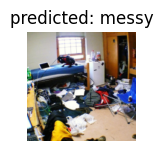

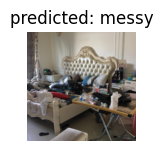

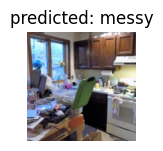

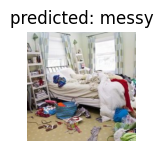

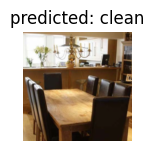

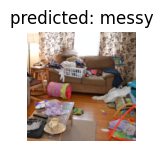

In [42]:
visualize_model(model_conv)

plt.ioff()
plt.show()


In [43]:
def visualize_model_predictions(model,img_path):
    was_training = model.training
    model.eval()

    img = Image.open(img_path)
    img = data_transforms['val'](img)
    img = img.unsqueeze(0)
    img = img.to(device)

    with torch.no_grad():
        outputs = model(img)
        _, preds = torch.max(outputs, 1)

        ax = plt.subplot(2,2,1)
        ax.axis('off')
        ax.set_title(f'Predicted: {class_names[preds[0]]}')
        imshow(img.cpu().data[0])

        model.train(mode=was_training)


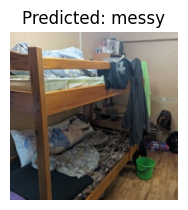

In [44]:
visualize_model_predictions(
    model_conv,
    img_path='./img/example01.jpg'
)

plt.ioff()
plt.show()


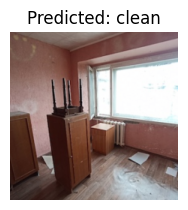

In [45]:
visualize_model_predictions(
    model_conv,
    img_path='./img/example02.jpg'
)

plt.ioff()
plt.show()


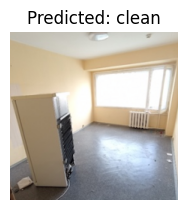

In [46]:
visualize_model_predictions(
    model_conv,
    img_path='./img/example03.jpg'
)

plt.ioff()
plt.show()


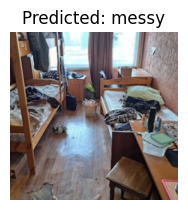

In [47]:
visualize_model_predictions(
    model_conv,
    img_path='./img/example04.jpg'
)

plt.ioff()
plt.show()


## Выделение признаков классификации

Используем алгоритм LIME


In [57]:
from lime import lime_image
from skimage.segmentation import mark_boundaries

def transform_image_for_model(img_path):
    img = Image.open(img_path).convert('RGB')
    img_tensor = data_transforms['val'](img)
    return img_tensor.unsqueeze(0).to(device)

def denormalize(tensor):
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3,1,1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3,1,1)
    return tensor.cpu() * std + mean

def batch_predict(images):
    model_conv.eval()
    batch = torch.stack([data_transforms['val'](Image.fromarray(img)).to(device) for img in images], dim=0)
    with torch.no_grad():
        logits = model_conv(batch)
    return torch.nn.functional.softmax(logits, dim=1).cpu().numpy()

def explain_prediction_with_lime(img_path):
    img = Image.open(img_path).convert('RGB').resize((256, 256))
    np_img = np.array(img)

    explainer = lime_image.LimeImageExplainer()
    explanation = explainer.explain_instance(
        np_img,
        batch_predict,
        top_labels=1,
        hide_color=0,
        num_samples=1000
    )

    temp, mask = explanation.get_image_and_mask(
        label=explanation.top_labels[0],
        positive_only=True,
        hide_rest=False,
        num_features=10,
        min_weight=0.0
    )

    plt.figure(figsize=(6, 6))
    plt.title(f"Predicted: {class_names[explanation.top_labels[0]]}")
    plt.imshow(mark_boundaries(temp / 255.0, mask))
    plt.axis('off')
    plt.show()


100%|██████████| 1000/1000 [00:14<00:00, 69.66it/s]


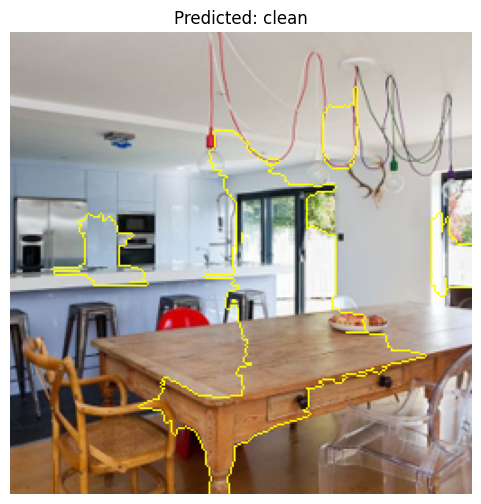

In [ ]:
explain_prediction_with_lime("./dataset/images/train/clean/1.png")


100%|██████████| 1000/1000 [00:14<00:00, 70.33it/s]


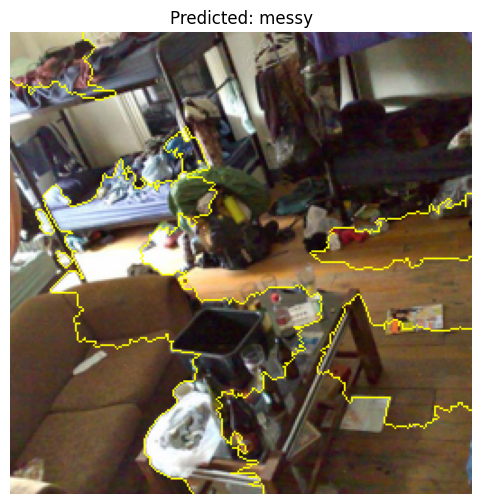

In [62]:
explain_prediction_with_lime("./dataset/images/train/messy/1.png")


100%|██████████| 1000/1000 [00:14<00:00, 71.15it/s]


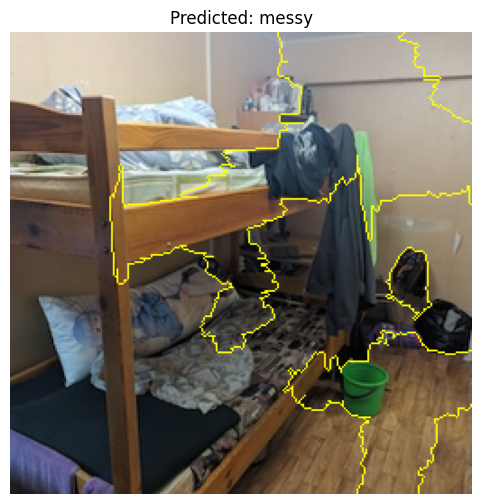

In [58]:
explain_prediction_with_lime("./img/example01.jpg")


100%|██████████| 1000/1000 [00:14<00:00, 68.56it/s]


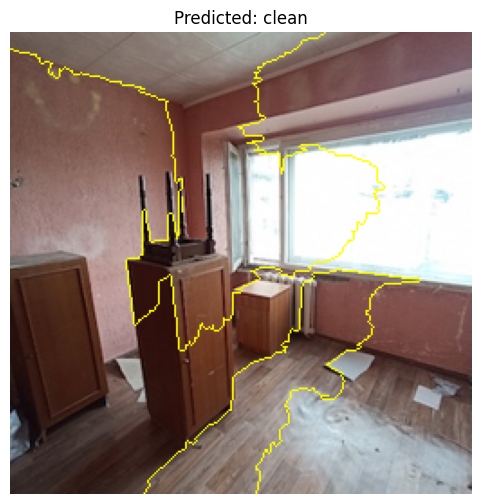

In [59]:
explain_prediction_with_lime("./img/example02.jpg")


100%|██████████| 1000/1000 [00:14<00:00, 70.27it/s]


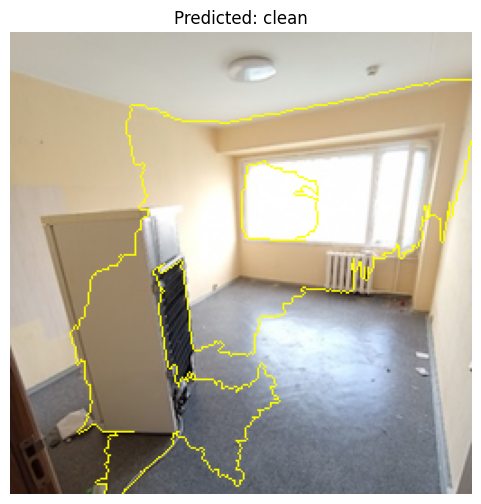

In [60]:
explain_prediction_with_lime("./img/example03.jpg")


100%|██████████| 1000/1000 [00:14<00:00, 70.57it/s]


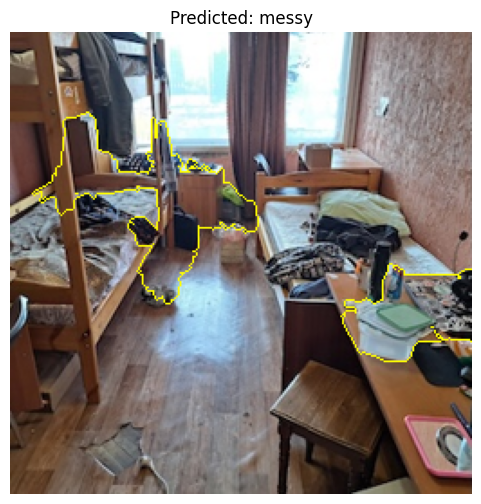

In [54]:
explain_prediction_with_lime("./img/example04.jpg")


## Вывод

Дообучил предобученную нейронную сеть, чтобы она смогла определять, является ли 
комната убранной или неубранной, также применил алгоритм LIME, чтобы выделить 
те признаки, которые повлияли на классификацию. В случае с неубранными 
помещениями алгоритм выделяет предметы, которые создают ощущение беспорядка. В 
случае с убранными помещениями выделение признаков не дает значимого 
результата, так как порядок характеризуется не наличием каких-либо объектов, а 
их отсутствием.
